## CMSC643 : Machine Learning 

## Mahdi Navari

## Project 2: Classification with Health Records

We will use data from the following Kaggle dataset: https://www.kaggle.com/joniarroba/noshowappointments.
The goal here is to predict patients that will not show up for medical appointments based on their medical records. You should read the dataset and task prediction in Kaggle to familiarize yourself as much as possible with the task and data.

# Part I: Data Preparation

- Fork my project skeleton github repo on github https://github.com/hcorrada/mldm_project2:
    - Click the ‘Fork’ button on the upper right
    - Go to your forked repository e.g., https://github.com//mldm_project2
    - Follow instructions there to clone the repository to your computer
    - See this for a quick overview of git: https://swcarpentry.github.io/git-novice/ 
- Download the dataset from http://www.hcbravo.org/dscert-mldm/ data/noshowappointments.zip. Unzip and copy the csv file on to the data directory in the project.
- Rename file partI_shell.ipynb to partI.ipynb
- Complete the partI.ipynb notebook
### This includes:
- Reading in data csv file
- Cleanup data column names
- Remove records with erroneous entries (e.g., negative ages, look at what people have done in Kaggle)
- Create a test set of 20k records that you won’t touch again for the reminder of this project until Part III. Use stratified sampling on the No-show variable to ensure test set and training set class proportions are the same. Save the train and test sets as csv files in the processed_data directory.
- Plot the No-show variable against the other variables in the dataset as part of Exploratory Data Analysis (USE THE TRAINING SET FOR THIS!!)
- Create a preprocessing pipeline using scikit to prepare the data for the ML algorithms we will use. At a minimum, standardize numerical variables, transform categorical variables into one or more numerical values. You may apply other transformations that you think would be useful (e.g., logarithmic transformations).


## Read data from csv

In [132]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

DATA_DIR = 'data'
CSV_FILE = DATA_DIR + '/'

# read data using read_csv function
appt_df = pd.read_csv(CSV_FILE + "KaggleV2-May-2016.csv")
appt_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [129]:
appt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


## Data cleanup

- Cleanup column names
- Remove records with erroneous entries (e.g., negative ages). Look at what people have done in Kaggle

In [80]:
# do data cleanup here
# highly recommend that you rename dataset
# e.g., if you used appt_df = pd.read_csv(...) above
# first thing to do here is clean_appt_df = appt_df
clean_appt_df = appt_df

clean_appt_df.rename(columns = {'Hipertension': 'Hypertension',
                         'Handcap': 'Handicap'}, inplace = True)

print(clean_appt_df.columns)

clean_appt_df.ScheduledDay = clean_appt_df.ScheduledDay.apply(np.datetime64)
clean_appt_df.AppointmentDay = clean_appt_df.AppointmentDay.apply(np.datetime64)
print(clean_appt_df.ScheduledDay.head(2))
print(clean_appt_df.AppointmentDay.head(2))




Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'No-show'],
      dtype='object')
0   2016-04-29 18:38:08
1   2016-04-29 16:08:27
Name: ScheduledDay, dtype: datetime64[ns]
0   2016-04-29
1   2016-04-29
Name: AppointmentDay, dtype: datetime64[ns]


### Compute hour of day an appointment was scheduled 

In [81]:
def calculate_hour_fraction(timestamp):
    timestamp = str(timestamp)
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    second = int(timestamp[17:])
    
    return round(hour + minute/60 + second/3600)

clean_appt_df['hour_of_app_scheduling'] = clean_appt_df.ScheduledDay.apply(calculate_hour_fraction)


### Separate HH:MM:SS from datetime 

In [133]:
def calculatedate_from_datetime(timestamp):
    timestamp = str(timestamp)
    date_vec = timestamp[0:10]
    return date_vec

clean_appt_df['ScheduleDate'] = clean_appt_df.ScheduledDay.apply(calculatedate_from_datetime)
#print (clean_appt_df['ScheduleDate'])

### Compute waiting time 

In [83]:
import datetime as dt
clean_appt_df['Waiting_time'] = (pd.to_datetime(clean_appt_df['AppointmentDay']) - pd.to_datetime(clean_appt_df['ScheduleDate'] )) / np.timedelta64(1, 'h')/24.0
#clean_appt_df['Waiting_time']

### Quick check of different fields in the dataframe 

In [84]:
print('Age:',sorted(clean_appt_df.Age.unique()))
print('Gender:',clean_appt_df.Gender.unique())
print('Diabetes:',clean_appt_df.Diabetes.unique())
print('Alcoholism:',clean_appt_df.Alcoholism.unique())
print('Hypertension:',clean_appt_df.Hypertension.unique())
print('Handicap:',clean_appt_df.Handicap.unique())
print('Scholarship:',clean_appt_df.Scholarship.unique())
print('SMS_received:',clean_appt_df.SMS_received.unique())
print('Waiting_time:',sorted(clean_appt_df.Waiting_time.unique()))
print('hour_of_app_scheduling:', sorted(clean_appt_df.hour_of_app_scheduling.unique()))    


Age: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]
Gender: ['F' 'M']
Diabetes: [0 1]
Alcoholism: [0 1]
Hypertension: [1 0]
Handicap: [0 1 2 3 4]
Scholarship: [0 1]
SMS_received: [0 1]
Waiting_time: [-6.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.

### Replace the nonsense values with the column median

In [134]:
mean_val = round(clean_appt_df.Age.median())
clean_appt_df.loc[~(clean_appt_df['Age'] > 0), 'Age'] = med_val
print('Age:',sorted(clean_appt_df.Age.unique()))
clean_appt_df.loc[(clean_appt_df['Age'] > 99), 'Age'] = med_val 
print('Age:',sorted(clean_appt_df.Age.unique()))

med_val = round(clean_appt_df.Waiting_time.median())
clean_appt_df.loc[~(clean_appt_df['Waiting_time'] > 0), 'Waiting_time'] = med_val
print('Waiting_time:',sorted(clean_appt_df.Waiting_time.unique()))

Age: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Age: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Waiting_time: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0

In [135]:
#clean_appt_df

## Test set creation

- Create a test set of 100k records
- Use stratified sampling on the `No-Show` variable to make sure class proportions are the same for train and test sets
- Save train and test sets as csv files in the `processed_data` directory

In [136]:
PROCESSED_DATA_DIR = 'processed_data'
print (clean_appt_df['No-show'].value_counts()/len(clean_appt_df))


# create test set with stratified sampling here
# refer to the intro notebook posted in class calendar for example
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
for train_index, test_index in split.split(clean_appt_df, clean_appt_df["No-show"]):
    train_set = clean_appt_df.loc[train_index]
    test_set = clean_appt_df.loc[test_index]
    
print (train_set["No-show"].value_counts() / len(train_set))
print (test_set["No-show"].value_counts() / len(test_set))


train_set.to_csv('train_data.csv')
test_set.to_csv('test_data.csv')

No     0.798067
Yes    0.201933
Name: No-show, dtype: float64
No     0.798068
Yes    0.201932
Name: No-show, dtype: float64
No     0.798064
Yes    0.201936
Name: No-show, dtype: float64


## Exploratory Data Analysis

Plot the `No-show` variable against other variables. Remember from this point forward you are only using the training set created in the previous step

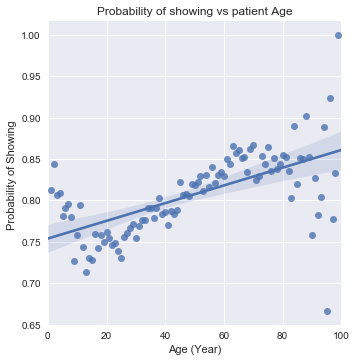

In [138]:
import seaborn as sns
df = pd.crosstab(train_set.Age , train_set['No-show']).apply(lambda r: r/r.sum(), axis=1).reset_index()

sns.lmplot(data = df, x = 'Age', y = 'No')
sns.plt.xlim(0, 100)
sns.plt.title('Probability of showing vs patient Age')
sns.plt.xlabel('Age (Year)')
sns.plt.ylabel('Probability of Showing ')
sns.plt.show()


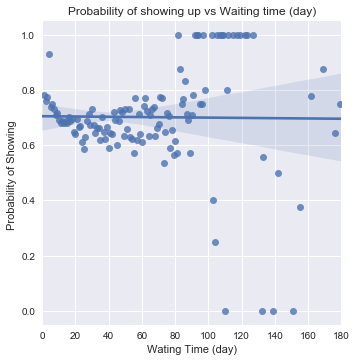

In [139]:
df = pd.crosstab(train_set.Waiting_time , train_set['No-show']).apply(lambda r: r/r.sum(), axis=1).reset_index()

sns.lmplot(data = df, x = 'Waiting_time', y = 'No')
sns.plt.xlim(0, 180)
sns.plt.title('Probability of showing up vs Waiting time (day)')
sns.plt.xlabel('Wating Time (day)')
sns.plt.ylabel('Probability of Showing ')
sns.plt.show()

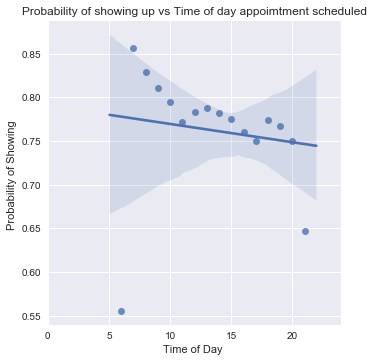

In [140]:
df = pd.crosstab(train_set.hour_of_app_scheduling , train_set['No-show']).apply(lambda r: r/r.sum(), axis=1).reset_index()

sns.lmplot(data = df, x = 'hour_of_app_scheduling', y = 'No')
sns.plt.xlim(0, 24)
sns.plt.title('Probability of showing up vs Time of day appoimtment scheduled')
sns.plt.xlabel('Time of Day ')
sns.plt.ylabel('Probability of Showing ')
sns.plt.show()

No-show Gender        No       Yes
0            F  0.796625  0.203375
1            M  0.800742  0.199258


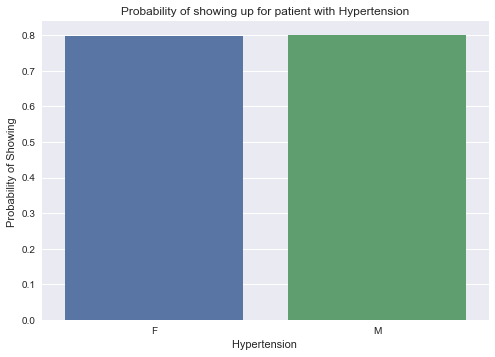

In [141]:
df = pd.crosstab(train_set.Gender , train_set['No-show']).apply(lambda r: r/r.sum(), axis=1).reset_index()
#df['Hypertension'] = df.index
print(df)

sns.barplot(data = df, x = 'Gender', y = 'No')

sns.plt.title('Probability of showing up for patient with Hypertension')
sns.plt.xlabel('Hypertension ')
sns.plt.ylabel('Probability of Showing ')
sns.plt.show()

No-show  Hypertension        No       Yes
0                   0  0.790491  0.209509
1                   1  0.828730  0.171270


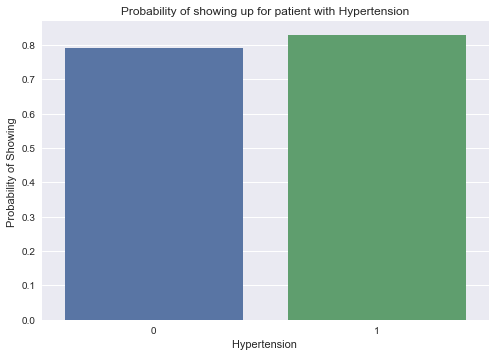

In [142]:
df = pd.crosstab(train_set.Hypertension , train_set['No-show']).apply(lambda r: r/r.sum(), axis=1).reset_index()
#df['Hypertension'] = df.index
print(df)

sns.barplot(data = df, x = 'Hypertension', y = 'No')

sns.plt.title('Probability of showing up for patient with Hypertension')
sns.plt.xlabel('Hypertension ')
sns.plt.ylabel('Probability of Showing ')
sns.plt.show()


No-show  Diabetes        No       Yes
0               0  0.796197  0.203803
1               1  0.822163  0.177837


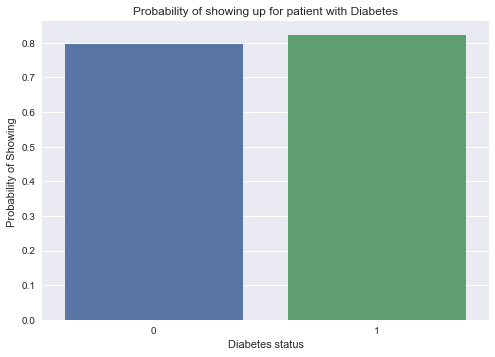

In [143]:
df = pd.crosstab(train_set.Diabetes , train_set['No-show']).apply(lambda r: r/r.sum(), axis=1).reset_index()
#df['Diabetes'] = df.index
print(df)

sns.barplot(data = df, x = 'Diabetes', y = 'No')
sns.plt.title('Probability of showing up for patient with Diabetes')
sns.plt.xlabel('Diabetes status')
sns.plt.ylabel('Probability of Showing ')
sns.plt.show()

No-show  Alcoholism        No       Yes
0                 0  0.797842  0.202158
1                 1  0.805257  0.194743


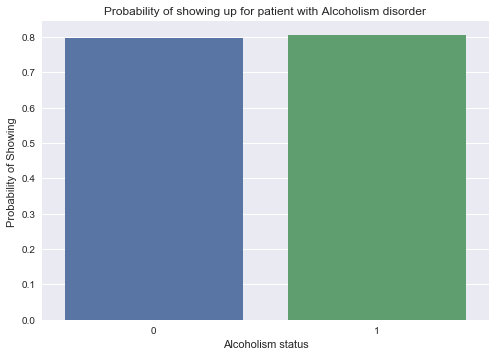

In [144]:
df = pd.crosstab(train_set.Alcoholism , train_set['No-show']).apply(lambda r: r/r.sum(), axis=1).reset_index()
#df['Alcoholism'] = df.index
print(df)

sns.barplot(data = df, x = 'Alcoholism', y = 'No')
sns.plt.title('Probability of showing up for patient with Alcoholism disorder')
sns.plt.xlabel('Alcoholism status')
sns.plt.ylabel('Probability of Showing ')
sns.plt.show()

No-show  Handicap        No       Yes
0               0  0.797687  0.202313
1               1  0.818800  0.181200
2               2  0.804054  0.195946
3               3  0.727273  0.272727
4               4  0.500000  0.500000


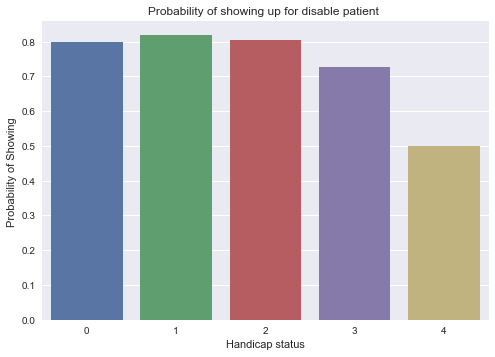

In [145]:
df = pd.crosstab(train_set.Handicap , train_set['No-show']).apply(lambda r: r/r.sum(), axis=1).reset_index()
#df['Handicap'] = df.index
print(df)

sns.barplot(data = df, x = 'Handicap', y = 'No')
sns.plt.title('Probability of showing up for disable patient ')
sns.plt.xlabel('Handicap status')
sns.plt.ylabel('Probability of Showing ')
sns.plt.show()

No-show  SMS_received        No       Yes
0                   0  0.832698  0.167302
1                   1  0.724737  0.275263


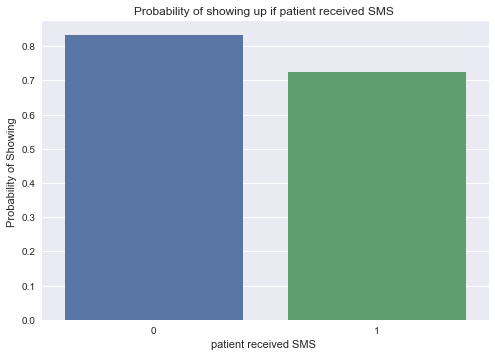

In [146]:

df = pd.crosstab(train_set.SMS_received , train_set['No-show']).apply(lambda r: r/r.sum(), axis=1).reset_index()
#df['SMS_received'] = df.index
print(df)

sns.barplot(data = df, x = 'SMS_received', y = 'No')
sns.plt.title('Probability of showing up if patient received SMS ')
sns.plt.xlabel('patient received SMS ')
sns.plt.ylabel('Probability of Showing ')
sns.plt.show()

In [147]:
train_set.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,hour_of_app_scheduling,ScheduleDate,Waiting_time
78966,9.328480e+13,5594887,F,2016-04-18 11:28:17,2016-05-02,33,BONFIM,0,0,0,0,0,0,No,11,2016-04-18,14.0
38168,3.976227e+13,5720410,F,2016-05-19 13:47:57,2016-05-24,73,MARIA ORTIZ,0,0,0,0,0,1,No,14,2016-05-19,5.0
89448,6.734196e+11,5756159,F,2016-06-01 08:01:29,2016-06-01,19,ILHA DAS CAIEIRAS,1,0,0,0,0,0,No,8,2016-06-01,4.0
69540,1.377846e+13,5690908,F,2016-05-12 10:54:37,2016-05-12,23,MARIA ORTIZ,0,0,0,0,0,0,No,11,2016-05-12,4.0
107050,2.424535e+13,5741742,M,2016-05-30 07:23:13,2016-06-01,35,CRUZAMENTO,0,0,0,0,0,0,No,7,2016-05-30,2.0


## Data preprocessing

Create a scikit pipeline for preprocessing the data to prepare it for ML algorithms. At a minimum your pipeline should:

- Standardize numerical variables
- Transform categorical variables into numeric variables

Optionally, you can perform any other transformation you think is suitable. Again, refer to the intro notebook for an example of setting up a preprocessing pipeline.

In [148]:
Patient = train_set
Patient = Patient.drop('PatientId', axis=1)
Patient = Patient.drop('AppointmentID', axis=1)
Patient = Patient.drop('ScheduledDay', axis=1)
Patient = Patient.drop('AppointmentDay', axis=1)
Patient = Patient.drop('Neighbourhood', axis=1)
Patient = Patient.drop('ScheduleDate', axis=1)
Patient = Patient.drop('No-show', axis=1)
Patient_labels = train_set['No-show'].copy()
print(Patient.head(2))
print(Patient_labels.head(2))

      Gender  Age  Scholarship  Hypertension  Diabetes  Alcoholism  Handicap  \
78966      F   33            0             0         0           0         0   
38168      F   73            0             0         0           0         0   

       SMS_received  hour_of_app_scheduling  Waiting_time  
78966             0                      11          14.0  
38168             1                      14           5.0  
78966    No
38168    No
Name: No-show, dtype: object


In [149]:
Patient.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 78966 to 10278
Data columns (total 10 columns):
Gender                    88421 non-null object
Age                       88421 non-null int64
Scholarship               88421 non-null int64
Hypertension              88421 non-null int64
Diabetes                  88421 non-null int64
Alcoholism                88421 non-null int64
Handicap                  88421 non-null int64
SMS_received              88421 non-null int64
hour_of_app_scheduling    88421 non-null int64
Waiting_time              88421 non-null float64
dtypes: float64(1), int64(8), object(1)
memory usage: 7.4+ MB


In [105]:
import nltk
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
# instal different version 
# conda install scikit-learn=0.18

The scikit-learn version is 0.18.2.


In [150]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, StandardScaler, LabelBinarizer,  LabelEncoder

# create pipeline here!
cat_attributes1 = ['Gender']
cat_attributes2 = ['Handicap']
num_attributes = ['Age' , 'hour_of_app_scheduling', 'Waiting_time']
binary_attributes = [x for x in list(Patient) if x not in cat_attributes + num_attributes]

# This is used to select columns from a pandas DataFrame 
# Needed since sklearn does not have builtin support for pandas
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attribute_names].values


num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attributes)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

cat_pipeline1 = Pipeline([
    ('selector', DataFrameSelector(cat_attributes1)),
    ('label_binarizer', LabelBinarizer())
])
#     ('label_Encoder', LabelEncoder()),

cat_pipeline2 = Pipeline([
    ('selector', DataFrameSelector(cat_attributes2)),
    ('label_binarizer', LabelBinarizer())
])

binary_pipeline = Pipeline([
    ('selector', DataFrameSelector(binary_attributes)),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline1', cat_pipeline1),
    ('cat_pipeline2', cat_pipeline2),
    ('binary_pipeline', binary_pipeline)
])
    
  
# show the first 5 rows of the transformed training set

In [153]:
Patient_clean = full_pipeline.fit_transform(Patient)


In [154]:
Patient_clean.shape

(88421, 14)

In [155]:
Patient_clean[1:5]

array([[ 1.55961279,  0.84753025, -0.4555153 ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [-0.79634987, -1.00598492, -0.52470297,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.62183412, -0.07922734, -0.52470297,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.09828686, -1.31490412, -0.66307831,  1.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]])

In [156]:
pd.DataFrame(Patient_clean)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.185545,-0.079227,0.167174,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.559613,0.847530,-0.455515,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.796350,-1.005985,-0.524703,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.621834,-0.079227,-0.524703,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.098287,-1.314904,-0.663078,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.447318,-0.388147,-0.247952,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,2.563078,-1.005985,-0.593891,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1.341468,0.538611,-0.663078,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.730663,-0.079227,-0.524703,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,1.123323,-1.314904,-0.524703,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
